In [168]:
import sys

sys.path.append("..")

%load_ext autoreload
%autoreload complete

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [270]:
from math import ceil
from pathlib import Path

import dask.array
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

from project.plotting import plot_field, format_plot, save_plot
from project.util import stack_state, unstack_state, TimeConverter
from project.spaces import PhysicalSpaceForecastSpaceMapper
from project.lim import LIM
from project.io import save_mfdataset
from project.kf import SerialEnSRF, create_initial_ensemble

In [256]:
data_true = xr.open_mfdataset(
    Path("/home/enkf6/dstiller/enspred/annual_averages/2023-12-08T00-58-19").glob("**/*.nc")
)
data_true = data_true.assign_coords(time=range(1, len(data_true.time) + 1))
data_true

<xarray.Dataset>
Dimensions:  (lon: 180, lat: 90, time: 1849)
Coordinates:
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * time     (time) int64 1 2 3 4 5 6 7 8 ... 1843 1844 1845 1846 1847 1848 1849
Data variables:
    ohc700   (time, lat, lon) float64 dask.array<chunksize=(100, 90, 180), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(100, 90, 180), meta=np.ndarray>
    psl      (time, lat, lon) float32 dask.array<chunksize=(100, 90, 180), meta=np.ndarray>
    rlut     (time, lat, lon) float32 dask.array<chunksize=(100, 90, 180), meta=np.ndarray>
    rsut     (time, lat, lon) float32 dask.array<chunksize=(100, 90, 180), meta=np.ndarray>
    sos      (time, lat, lon) float32 dask.array<chunksize=(100, 90, 180), meta=np.ndarray>
    tas      (time, lat, lon) float32 dask.array<chunksize=(100, 90, 180), meta=np.ndarray>
    tos      (time, lat, lon) float32 dask.array<chunksize=(100, 90, 180), meta=np.ndarray>
    zg500    (time, lat, lon) float32 dask.array<chunksize=(100, 90, 180), meta=np.ndarray>
    zos      (time, lat, lon) float32 dask.array<chunksize=(100, 90, 180), meta=np.ndarray>
    century  (time) int64 dask.array<chunksize=(100,), meta=np.ndarray>

In [170]:
obs = xr.open_mfdataset(
    Path("/home/enkf6/dstiller/enspred/obs/2023-12-09T21-21-21").glob("**/*.nc")
).set_xindex(["lon", "lat"])
obs

<xarray.Dataset>
Dimensions:   (time: 999, location: 364)
Coordinates:
  * time      (time) int64 850 851 852 853 854 855 ... 1844 1845 1846 1847 1848
  * location  (location) object MultiIndex
  * lon       (location) float64 0.0 2.0 4.0 6.0 6.0 ... 356.0 356.0 356.0 358.0
  * lat       (location) float64 43.0 43.0 41.0 -75.0 ... 35.0 37.0 43.0 -75.0
Data variables:
    tas       (time, location) float32 dask.array<chunksize=(100, 364), meta=np.ndarray>

In [171]:
initial = xr.open_mfdataset(
    Path("/home/enkf6/dstiller/enspred/forecast/2023-12-07T23-41-56").glob("**/*.nc")
).drop_vars("century")
initial = initial.assign_coords(time=range(1, len(initial.time) + 1)).sel(time=slice(850, 850))
initial

<xarray.Dataset>
Dimensions:  (lon: 180, lat: 90, time: 1)
Coordinates:
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * time     (time) int64 850
Data variables:
    ohc700   (time, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    pr       (time, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    psl      (time, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    rlut     (time, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    rsut     (time, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    sos      (time, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    tas      (time, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    tos      (time, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    zg500    (time, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    zos      (time, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>

In [172]:
mapper = PhysicalSpaceForecastSpaceMapper.load(
    Path("/home/enkf6/dstiller/enspred/mapper/mapper-2023-12-08T00-12-39.pkl")
)

In [173]:
lim = LIM.load(Path("/home/enkf6/dstiller/enspred/lim/lim-2023-12-09T20-20-50.pkl"))

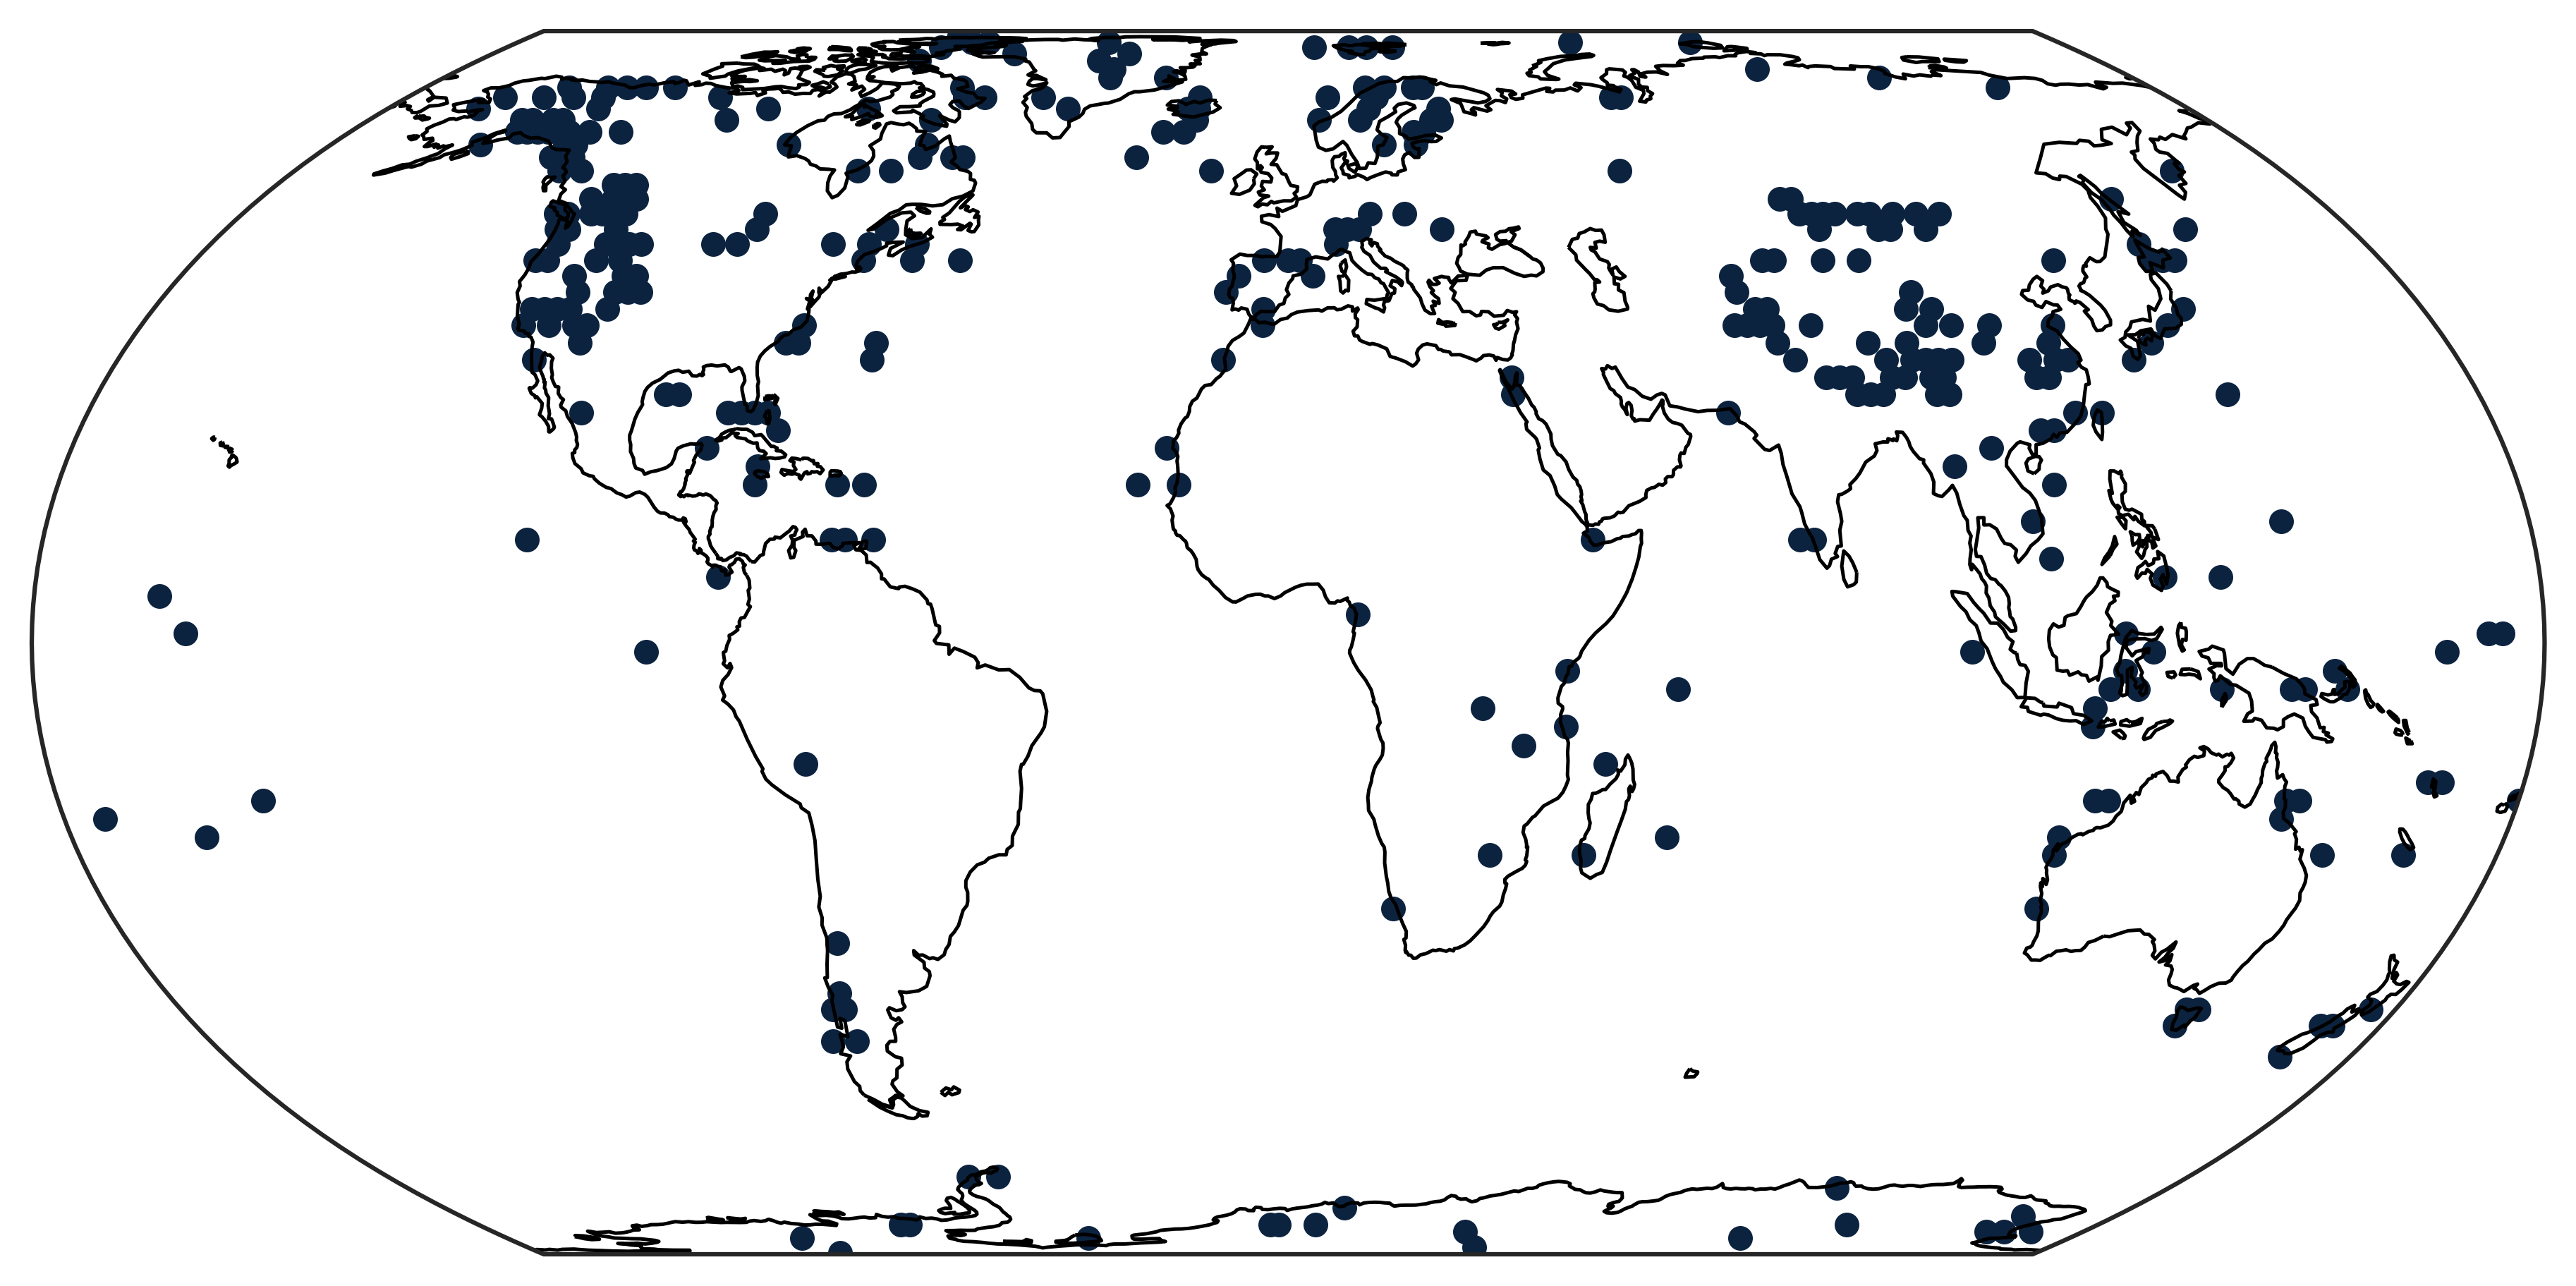

In [174]:
fig, ax = plt.subplots(
    figsize=(8, 4),
    subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=0)),
)

ax.scatter(obs.lon, obs.lat, transform=ccrs.PlateCarree())
ax.coastlines()

In [259]:
initial_state = xr.DataArray(
    mapper.forward(initial), coords=dict(state=range(50), time=initial.time)
)
fc_state = lim.forecast_stochastic(initial_state, 1, 10, 1440, initial.time.item()).isel(
    time=slice(-1)
)
fc_physical = mapper.backward_ensemble(fc_state)
fc_physical

2023-12-09 23:32:16    INFO PhysicalSpaceForecastSpaceMapper.forward()
2023-12-09 23:32:16    INFO Splitting dataset into Dask arrays


2023-12-09 23:32:16    INFO Masking nans
2023-12-09 23:32:16    INFO Detrending data
2023-12-09 23:32:16    INFO Standardizing pr before individual EOF
2023-12-09 23:32:16    INFO Projecting EOF for ohc700 [1/10]
2023-12-09 23:32:16    INFO Standardizing ohc700 after individual EOF
2023-12-09 23:32:16    INFO Projecting EOF for pr [2/10]
2023-12-09 23:32:16    INFO Projecting EOF for psl [3/10]
2023-12-09 23:32:16    INFO Standardizing psl after individual EOF
2023-12-09 23:32:16    INFO Projecting EOF for rlut [4/10]
2023-12-09 23:32:16    INFO Standardizing rlut after individual EOF
2023-12-09 23:32:17    INFO Projecting EOF for rsut [5/10]
2023-12-09 23:32:17    INFO Standardizing rsut after individual EOF
2023-12-09 23:32:17    INFO Projecting EOF for sos [6/10]
2023-12-09 23:32:17    INFO Standardizing sos after individual EOF
2023-12-09 23:32:17    INFO Projecting EOF for tas [7/10]
2023-12-09 23:32:17    INFO Standardizing tas after individual EOF
2023-12-09 23:32:17    INFO Pro

<xarray.Dataset>
Dimensions:  (lon: 180, lat: 90, ens: 10)
Coordinates:
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
    time     float64 850.0
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    ohc700   (ens, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    pr       (ens, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    psl      (ens, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    rlut     (ens, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    rsut     (ens, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    sos      (ens, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    tas      (ens, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    tos      (ens, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    zg500    (ens, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    zos      (ens, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>

In [322]:
prio = (
    xr.open_mfdataset(
        Path("/home/enkf6/dstiller/enspred/annual_averages/2023-12-09T23-33-06").glob("**/*.nc")
    )
    .isel(time=0)
    .expand_dims("time")
)
mapper.forward_ensemble(create_initial_ensemble(prio, 10))

2023-12-10 00:16:46    INFO PhysicalSpaceForecastSpaceMapper.forward()
2023-12-10 00:16:46    INFO Splitting dataset into Dask arrays
2023-12-10 00:16:46    INFO Masking nans
2023-12-10 00:16:46    INFO Detrending data
2023-12-10 00:16:46    INFO Standardizing pr before individual EOF
2023-12-10 00:16:46    INFO Projecting EOF for ohc700 [1/10]
2023-12-10 00:16:46    INFO Standardizing ohc700 after individual EOF
2023-12-10 00:16:46    INFO Projecting EOF for pr [2/10]
2023-12-10 00:16:46    INFO Projecting EOF for psl [3/10]
2023-12-10 00:16:46    INFO Standardizing psl after individual EOF
2023-12-10 00:16:46    INFO Projecting EOF for rlut [4/10]
2023-12-10 00:16:46    INFO Standardizing rlut after individual EOF
2023-12-10 00:16:46    INFO Projecting EOF for rsut [5/10]
2023-12-10 00:16:47    INFO Standardizing rsut after individual EOF
2023-12-10 00:16:47    INFO Projecting EOF for sos [6/10]
2023-12-10 00:16:47    INFO Standardizing sos after individual EOF
2023-12-10 00:16:47   

<xarray.Dataset>
Dimensions:                                       (state: 50, time: 1, ens: 10)
Coordinates:
  * state                                         (state) int64 0 1 2 ... 48 49
  * time                                          (time) int64 1
  * ens                                           (ens) int64 0 1 2 3 ... 7 8 9
Data variables:
    concatenate-2c7806095883873d68cba298d01f51a7  (ens, state, time) float64 dask.array<chunksize=(10, 30, 1), meta=np.ndarray>
    concatenate-46358cd0fcbf797f59940475e7a6ff39  (ens, state, time) float64 dask.array<chunksize=(10, 30, 1), meta=np.ndarray>
    concatenate-5a9d87d484c5728318bd86b5191db798  (ens, state, time) float64 dask.array<chunksize=(10, 30, 1), meta=np.ndarray>
    concatenate-70ad808fda987de32e55e058853a6432  (ens, state, time) float64 dask.array<chunksize=(10, 30, 1), meta=np.ndarray>
    concatenate-8b3d703618cc492f2ff48abec585661a  (ens, state, time) float64 dask.array<chunksize=(10, 30, 1), meta=np.ndarray>
    concatenate-9fa90ffcf8fa3c9d0305e46ba8f9d2c5  (ens, state, time) float64 dask.array<chunksize=(10, 30, 1), meta=np.ndarray>
    concatenate-bc95d0db0cf51ff1bd502e3409eb8e76  (ens, state, time) float64 dask.array<chunksize=(10, 30, 1), meta=np.ndarray>
    concatenate-cd49483d29d9069fc6f1fe364cddbb75  (ens, state, time) float64 dask.array<chunksize=(10, 30, 1), meta=np.ndarray>
    concatenate-dfd8be2ca30d561636161714748c51e3  (ens, state, time) float64 dask.array<chunksize=(10, 30, 1), meta=np.ndarray>
    concatenate-e41875da7a20d875864ada5c2cb6b696  (ens, state, time) float64 dask.array<chunksize=(10, 30, 1), meta=np.ndarray>

In [347]:
assim = SerialEnSRF().assimilate(
    fc_physical, obs.sel(time=fc_physical.time).isel(location=slice(3)), 1
)
assim

/home/disk/p/dstiller/.local/software/miniconda3/envs/enspred/lib/python3.11/site-packages/dask/array/routines.py:443: PerformanceWarning: Increasing number of chunks by factor of 10
  out = blockwise(
/home/disk/p/dstiller/.local/software/miniconda3/envs/enspred/lib/python3.11/site-packages/dask/array/routines.py:443: PerformanceWarning: Increasing number of chunks by factor of 10
  out = blockwise(
/home/disk/p/dstiller/.local/software/miniconda3/envs/enspred/lib/python3.11/site-packages/dask/array/routines.py:443: PerformanceWarning: Increasing number of chunks by factor of 10
  out = blockwise(
/home/disk/p/dstiller/.local/software/miniconda3/envs/enspred/lib/python3.11/site-packages/dask/array/routines.py:443: PerformanceWarning: Increasing number of chunks by factor of 10
  out = blockwise(
/home/disk/p/dstiller/.local/software/miniconda3/envs/enspred/lib/python3.11/site-packages/dask/array/routines.py:443: PerformanceWarning: Increasing number of chunks by factor of 10
  out = b

<xarray.Dataset>
Dimensions:  (time: 1, ens: 10, lon: 180, lat: 90)
Coordinates:
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 9
  * time     (time) float64 850.0
Data variables:
    ohc700   (time, ens, lon, lat) float64 dask.array<chunksize=(1, 1, 180, 90), meta=np.ndarray>
    pr       (time, ens, lon, lat) float64 dask.array<chunksize=(1, 1, 180, 90), meta=np.ndarray>
    psl      (time, ens, lon, lat) float64 dask.array<chunksize=(1, 1, 180, 90), meta=np.ndarray>
    rlut     (time, ens, lon, lat) float64 dask.array<chunksize=(1, 1, 180, 90), meta=np.ndarray>
    rsut     (time, ens, lon, lat) float64 dask.array<chunksize=(1, 1, 180, 90), meta=np.ndarray>
    sos      (time, ens, lon, lat) float64 dask.array<chunksize=(1, 1, 180, 90), meta=np.ndarray>
    tas      (time, ens, lon, lat) float64 dask.array<chunksize=(1, 1, 180, 90), meta=np.ndarray>
    tos      (time, ens, lon, lat) float64 dask.array<chunksize=(1, 1, 180, 90), meta=np.ndarray>
    zg500    (time, ens, lon, lat) float64 dask.array<chunksize=(1, 1, 180, 90), meta=np.ndarray>
    zos      (time, ens, lon, lat) float64 dask.array<chunksize=(1, 1, 180, 90), meta=np.ndarray>